<a href="https://colab.research.google.com/github/macwolfz/DZDeepLearningCancerClassification/blob/main/ModeloKerasLabCollab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf

In [18]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [19]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [20]:
import os
import glob
import pathlib
#from shutil import copyfile
import shutil
from sys import exit
import matplotlib.pyplot as plt
from shutil import copyfile
#import keras.backend.tensorflow_backend as tfback

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [22]:
import pydotplus
import graphviz

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
num_skipped = 0
for folder_name in ("cancer", "no_cancer"):
    folder_path = os.path.join("/content/gdrive/MyDrive/Collab Notebooks/LungCells", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)
#

Deleted 0 images


In [54]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Collab Notebooks/LungCells",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Collab Notebooks/LungCells",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 3614 files belonging to 7 classes.
Using 2892 files for training.
Found 3614 files belonging to 7 classes.
Using 722 files for validation.


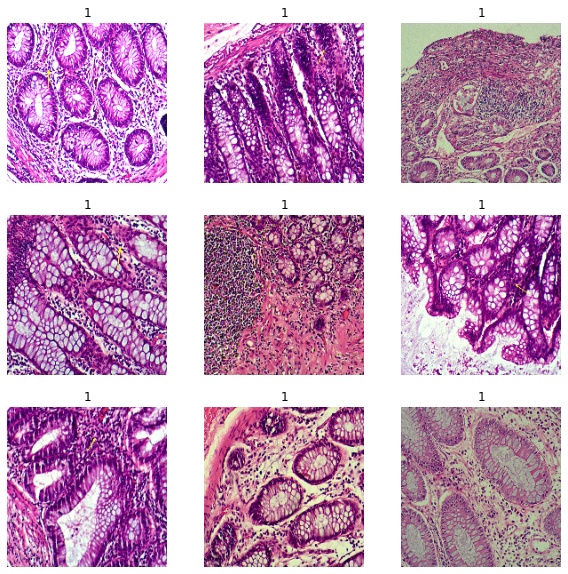

In [25]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [55]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [56]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

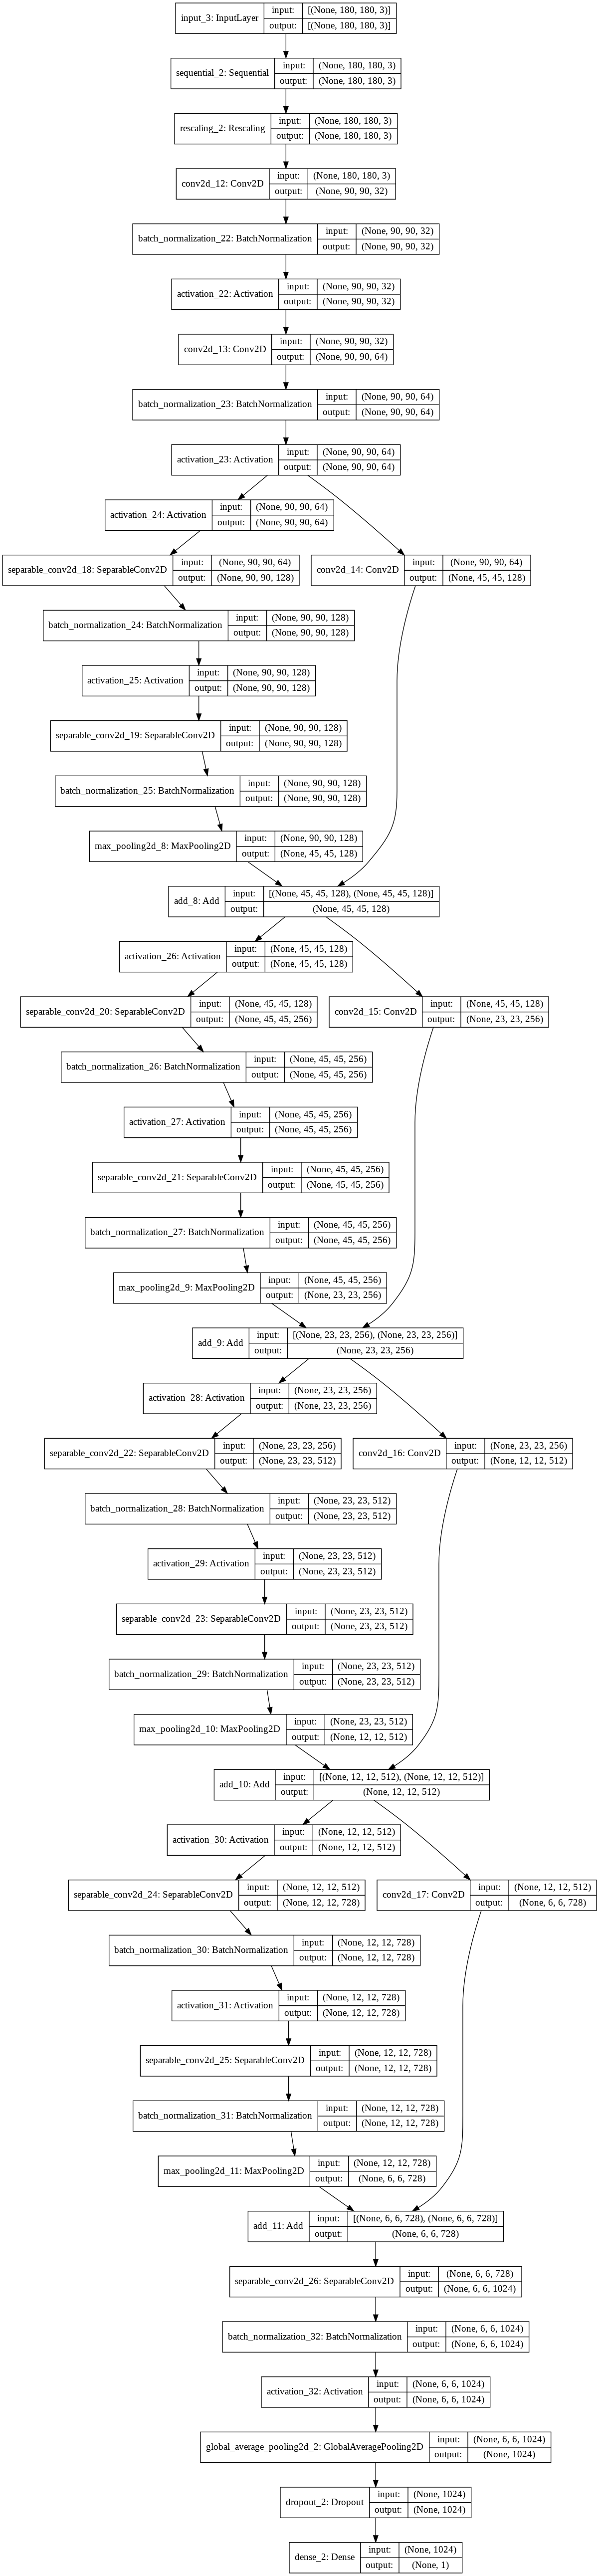

In [57]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [59]:
epochs = 80
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

91/91 [==============================] - 56s 575ms/step - loss: -163730.5071 - accuracy: 0.0468 - val_loss: -183450.6875 - val_accuracy: 0.0277
Epoch 60/80
18/91 [====>.........................] - ETA: 34s - loss: -166462.6632 - accuracy: 0.0541

KeyboardInterrupt: ignored

This image is 0.00 percent Cancer and 100.00 percent No Cancer.


**Load** 06/206 [==============================] - 121s 585ms/step - loss: 0.0386 - accuracy: 0.9853 - val_loss: 0.0577 - val_accuracy: 0.9787
Epoch 49/50

In [60]:
from tensorflow.keras.models import load_model
new_model = load_model('/content/gdrive/MyDrive/Collab Notebooks/LungCells/Pesos/save_at_46.h5')
new_model.summary()
new_model.get_weights()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
_______________________________________________________________________________________

[array([[[[ 8.48110914e-02, -2.21373424e-01, -4.60414514e-02,
            4.84620631e-02, -6.11689351e-02, -4.02461737e-02,
           -1.69203371e-01,  2.95951478e-02,  1.37126865e-02,
           -2.93533616e-02,  1.62007600e-01,  1.50402680e-01,
           -2.38921046e-02,  2.02640608e-01, -1.93817765e-01,
            1.37415215e-01, -2.80962288e-01, -1.63543552e-01,
           -2.21446067e-01, -3.19200844e-01,  7.95183480e-02,
           -4.01126184e-02,  4.52703349e-02, -6.26909286e-02,
           -6.36408255e-02,  1.72646105e-01,  2.82669049e-02,
           -2.64602005e-02,  4.66614477e-02, -8.31334069e-02,
           -1.33223042e-01,  9.01344344e-02],
          [-4.41463105e-02,  1.60833284e-01,  1.27373829e-01,
           -1.09721184e-01,  9.27734375e-02,  4.77429032e-02,
            6.41964301e-02,  2.10533276e-01,  5.66951707e-02,
            1.74760148e-02, -1.46684289e-01,  2.19788298e-01,
           -1.19471788e-01,  2.34229773e-01, -6.70697391e-02,
            6.88099070e-

In [61]:
img = keras.preprocessing.image.load_img(
    "/content/gdrive/MyDrive/Collab Notebooks/LungCells/seg_pred/seg_pred/114_non_cancer_test.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = new_model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Cancer and %.2f percent No Cancer."
    % (100 * (1 - score), 100 * score)
)

This image is 0.04 percent Cancer and 99.96 percent No Cancer.


In [47]:
pred_path='/content/gdrive/MyDrive/Collab Notebooks/LungCells/seg_pred/seg_pred'
#categories
images_path=glob.glob(pred_path+'/*.jpg')

In [48]:
target_cancer = "/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/cancer"
target_no_cancer = "/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/no_cancer"
target_others = "/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/not_Clear"

In [52]:
num_cancer = 0
num_no_cancer = 0
num_otros = 0
predictions={}

for i in images_path:
    img = keras.preprocessing.image.load_img(
    i, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = new_model.predict(img_array)
    score = predictions[0]
    res = i.partition(pred_path)[2]
    print(res[1:])
    if "non_cancer" in res and (100 * score)>50:
        print("no tiene cancer")
        num_no_cancer += 1
        # adding exception handling
        try:
            copyfile(i, target_no_cancer+res)
        except IOError as e:
            print("Unable to copy file. %s" % e)
            exit(1)
        except:
            print("Unexpected error:", sys.exc_info())
            exit(1)
            
    elif "non_cancer" not in res and (100*(1-score))> 50:
        print("tiene cancer")
        num_cancer+=1
        # adding exception handling
        try:
            copyfile(i, target_cancer+res)
        except IOError as e:
            print("Unable to copy file. %s" % e)
            exit(1)
        except:
            print("Unexpected error:", sys.exc_info())
            exit(1)
    else:
        print("ERROR")
        print(100*score)
        print(100*(1-score))
        num_otros += 1
        # adding exception handling
        try:
            copyfile(i, target_others+res)
        except IOError as e:
            print("Unable to copy file. %s" % e)
            exit(1)
        except:
            print("Unexpected error:", sys.exc_info())
            exit(1)
                               
    print(
    "This image is %.2f percent Cancer and %.2f percent No Cancer."
    % (100 * (1 - score), 100 * score)
    )
    print("\n")
   


23_non_cancer_test.jpg
ERROR
[42.76792]
[57.232082]
This image is 57.23 percent Cancer and 42.77 percent No Cancer.


23_cancer_test.jpg
tiene cancer
This image is 99.98 percent Cancer and 0.02 percent No Cancer.


22_non_cancer_test.jpg
no tiene cancer
This image is 0.00 percent Cancer and 100.00 percent No Cancer.


22_cancer_test.jpg
tiene cancer
This image is 99.98 percent Cancer and 0.02 percent No Cancer.


106_non_cancer_test.jpg
no tiene cancer
This image is 13.05 percent Cancer and 86.95 percent No Cancer.


108_non_cancer_test.jpg
no tiene cancer
This image is 0.00 percent Cancer and 100.00 percent No Cancer.


109_non_cancer_test.jpg
no tiene cancer
This image is 0.03 percent Cancer and 99.97 percent No Cancer.


107_non_cancer_test.jpg
no tiene cancer
This image is 0.01 percent Cancer and 99.99 percent No Cancer.


105_non_cancer_test.jpg
no tiene cancer
This image is 0.00 percent Cancer and 100.00 percent No Cancer.


104_non_cancer_test.jpg
no tiene cancer
This image is 0

In [53]:
print("有肺癌的人：",num_cancer)
print("没有肺癌的人：",num_no_cancer)
print("另外的图片：",num_otros)

有肺癌的人： 54
没有肺癌的人： 83
另外的图片： 11


In [63]:
import glob, os, os.path

filelist = glob.glob(os.path.join("/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/cancer", "*.jpg"))
for f in filelist:
    os.remove(f)
filelist = glob.glob(os.path.join("/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/no_cancer", "*.jpg"))
for f in filelist:
    os.remove(f)
filelist = glob.glob(os.path.join("/content/gdrive/MyDrive/Collab Notebooks/LungCells/Output/not_Clear", "*.jpg"))
for f in filelist:
    os.remove(f)

